# Calculate near surface RH% using ERA-interim fields

* 2-m dew point
* 2-m temperature
* surface pressure

NOTE: RH was calculated from raw, native (0.75 x 0.75 deg grid) era-interim nc data. These data live in a different project directory (metSpreadData).   

Link to documentations and instructions on how to calculate near surface relative humidity using ecmwf era-interim:
https://www.ecmwf.int/en/faq/do-era-datasets-contain-parameters-near-surface-humidity

\begin{align}
RH=100\frac{es(T_{d})}{es(T)}
\end{align}

### Saturation Specific Humidity

Saturation specific humidity is expressed as a function of saturation water vapor pressure as:

\begin{align}
q_{sat} & = \frac{e_{sat}(T)\frac{R_{dry}}{R_{vapor}}}{p-(1-\frac{R_{dry}}{R_{vapor}})e_{sat}(T)}
\end{align}

where the saturation water vopor pressure ($e_{sat}$) is expressed with the Teten's formula:
\begin{align}
e_{sat}(T) & = a_{1}exp(a_{3}\frac{T - T_{0}}{T-a_{4}})\\
\\
a_{1} & = 611.21Pa \\
a_{3} & = 17.502 \\
a_{4} & = 32.19 \\
T_{0} & = 273.16
\end{align}

In [1]:
import numpy as np

def calculat_svp(T, P):
    """Calculates and returns saturation vapor pressure (svp)"""
    # constants for saturation over water 
    a1 = 611.21 # Pa
    a3 = 17.502
    a4 = 32.19 # K
    To = 273.16 # K 
    R_dry = 287. # J/kg/K gas constant of dry air
    R_vap = 461. # J/kg/K gas constant for water vapor 

    e_sat = a1 * np.exp( a3 * (T-To)/(T-a4) )

    # Saturation specific humidity (eqn 7.4)
    top = e_sat * R_dry / R_vap 
    bottom = P - (1. - R_dry / R_vap) * e_sat  
    q_sat = top / bottom
    
    return q_sat 

### Create 3D RH arrays

In [65]:
from netCDF4 import Dataset
import os
from matplotlib import pylab as plt
dataDir = "/../../metSpreadData/ERA-Interim"

def get_nc(var, year): 
    loadFile = os.path.join(dataDir, var + "_" + str(year) + ".nc")
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    t = nc.variables["time"][:]
    lon = nc.variables["longitude"][:]
    lat = nc.variables["latitude"][:]
    nc.close()
    return vals, t, lon, lat


def write_RH_nc(RH, t, x, y, year, dataDir):
    
    outputFile = os.path.join(dataDir, "RH_" + str(year) + ".nc")

    ncFile = Dataset(outputFile, 'w', format='NETCDF4')
    ncFile.description = 'Relative Humidity (saturation pressure relative to water, Tetons eq.)'
    ncFile.location = 'Global'
    ncFile.createDimension('time',  len(t) )
    ncFile.createDimension('latitude', len(y) )
    ncFile.createDimension('longitude', len(x) )

    VAR_ = ncFile.createVariable("RH", 'f4',('time', 'latitude','longitude'))
    VAR_.long_name = "Relative Humidity"
    VAR_.units = "%"

    # Create time variable
    time_ = ncFile.createVariable('time', 'i4', ('time',))
    time_.units = "hours since 1900-01-01 00:00:0.0"
    time_.calendar = "gregorian"
    
    # create lat variable
    latitude_ = ncFile.createVariable('latitude', 'f4', ('latitude',))
    latitude_.units = 'degrees_north'

    # create longitude variable
    longitude_ = ncFile.createVariable('longitude', 'f4', ('longitude',))
    longitude_.units = 'degrees_east'

    # Write the actual data to these dimensions
    VAR_[:]       = RH
    time_[:]      = t
    latitude_[:]  = y
    longitude_[:] = x

    ncFile.close()

Generate the RH yearly files!

In [66]:
years = range(1990, 2016)
for year in years:
    
    # Get the grids needed to calculate specific humidity
    t2m,t,x,y = get_nc("t2m", year)
    d2m,t,x,y = get_nc("d2m", year)
    sp,t,x,y  = get_nc("sp", year)

    RH = calculat_svp(d2m, sp) / calculat_svp(t2m, sp) * 100.
    write_RH_nc(RH, t, x, y, year, dataDir)

Show the last month for the last year output as an example of what these values and output look like. 
Make sure the dry places in the world have lower RH values. 

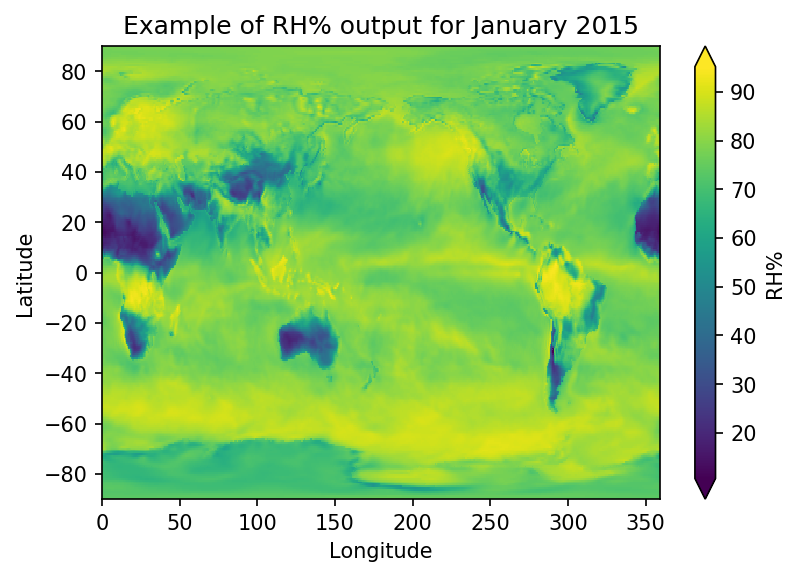

In [67]:
plt.figure(dpi=150)
plt.pcolor(x,y,RH[0,:,:])
plt.title("Example of RH% output for January 2015")
plt.colorbar(extend="both", label="RH%")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()